<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/sbi_lens/blob/u%2FJustinezgh%2Ftrain_class/notebooks/dev/Demo_train_compressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/sbi_lens@u/Justinezgh/update_utils_functions
!pip install --quiet dm-haiku
%pylab inline

from functools import partial
import jax
import jax.numpy as jnp
from numpyro.handlers import seed, condition
from sbi_lens.simulator import lensingLogNormal
from jax.random import PRNGKey as key

import haiku as hk
from haiku._src.nets.resnet import ResNet18
from sbi_lens.normflow.models import AffineSigmoidCoupling, ConditionalRealNVP
import optax

from sbi_lens.simulator.utils import get_samples_and_scores

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/usr/local/lib/python3.9/dist-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


In [2]:
# define model 

N = 20 
nb_bins = 5

model = partial(lensingLogNormal,
                model_type='lognormal',
                N = N,
                with_noise=True)

# condition the model on a given set of parameters
fiducial_model = condition(model, {'omega_c': 0.3, 
                                   'omega_b': 0.0492,
                                   'sigma_8': 0.8,
                                   'h_0': 0.7,
                                   'n_s': 0.9,
                                   'w_0': -1.0})

# sample a mass map
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(42))
m_data = sample_map_fiducial()

/usr/local/lib/python3.9/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.9/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/usr/local/lib/python3.9/dist-packages/jax_cosmo/scipy/interpolate.py:37: UserWarnin

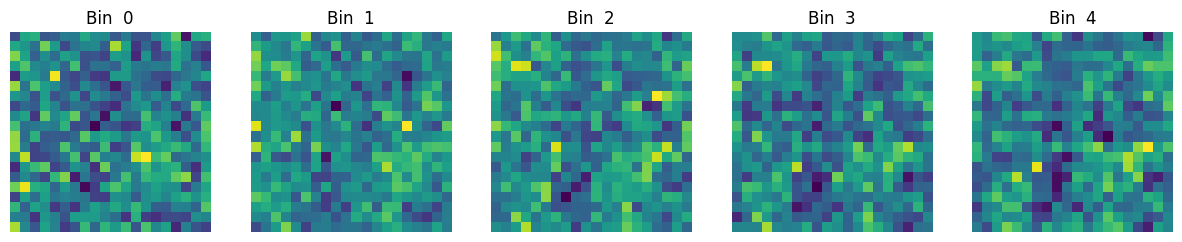

In [3]:
figure(figsize=[15,5])
for i in range(5):
    subplot(1,5,i+1)
    imshow(m_data[...,i])
    title('Bin % d' % i)
    axis('off')

In [4]:
# create get_batch function (will be replace by the dataset)

# @jax.jit (still have to fixe this issue --')
def get_batch(key):
  (logp, samples), scores = get_samples_and_scores(
        model,
        key,
        batch_size=10,
  )
  return samples, scores

In [5]:
simu, score = get_batch(key(0))

In [6]:
print('score shape: ', score.shape)
print('simu params shape: ', simu['theta'].shape)
print('simu mass map shape: ', simu['y'].shape)

score shape:  (10, 6)
simu params shape:  (10, 6)
simu mass map shape:  (10, 20, 20, 5)


In [20]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from tqdm import tqdm
from functools import partial


class train_model():

    def loss_mse(self, params, theta, x, state_resnet):
      
        y, opt_state_resnet = self.compressor.apply(
            params, 
            state_resnet,
            None, 
            x.reshape([-1, self.nb_pixels, self.nb_pixels, self.nb_bins])
        )

        loss = jnp.mean(jnp.sum((y - theta)**2, axis=1))

        return loss, opt_state_resnet


    def loss_vmim(self, params, theta, x, state_resnet):

        y, opt_state_resnet = self.compressor.apply(
            params, 
            state_resnet,
            None, 
            x.reshape([-1, self.nb_pixels, self.nb_pixels, self.nb_bins])
        )
        log_prob = jax.vmap(
            lambda theta, x: self.nf.apply(
                params, 
                theta.reshape([1,6]), 
                x.reshape([1,6])
            ).squeeze()
        )(theta, y)

        return -jnp.mean(log_prob), opt_state_resnet


    def __init__(
        self,
        compressor,
        nf,
        optimizer,
        loss_name, 
        nb_pixels, 
        nb_bins
    ):

        self.compressor = compressor
        self.nf = nf
        self.optimizer = optimizer
        self.nb_pixels = nb_pixels
        self.nb_bins = nb_bins


        if loss_name == ' mse': 
            self.loss = self.loss_mse
        elif loss_name == 'vmim': 
            self.loss = self.loss_vmim


    @partial(jax.jit, static_argnums=(0,))
    def update(
        self,
        model_params,
        opt_state,
        theta,
        x,
        state_resnet
    ):

        (loss, opt_state_resnet), grads = jax.value_and_grad(
                self.loss, 
                has_aux = True
            )(model_params, theta, x, state_resnet)

        updates, new_opt_state = self.optimizer.update(
            grads, 
            opt_state
        )

        new_params = optax.apply_updates(
            model_params, 
            updates
        )
      
        return loss, new_params, new_opt_state, opt_state_resnet

In [21]:
# create compressor 

# nf
bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers_compressor, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_compressor = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_compressor
)

class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(2)(y)
        return nvp

nf = hk.without_apply_rng(
    hk.transform(
        lambda theta, y : Flow_nd_Compressor()(y).log_prob(theta).squeeze()
    )
)


# compressor
compressor = hk.transform_with_state(lambda x : ResNet18(6)(x, is_training=True))

In [22]:
# init compressor
parameters_resnet, opt_state_resnet  = compressor.init(key(0), 0.5*jnp.ones([1,N,N,nb_bins]))
# init nf
params_nf = nf.init(key(0),  0.5*jnp.ones([1, 6]), 0.5*jnp.ones([1, 6]))
# merge params
parameters_compressor = hk.data_structures.merge(parameters_resnet, params_nf)

# define optimizer
total_steps = 100 
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={int(total_steps*0.1):0.7,
                           int(total_steps*0.2):0.7,
                           int(total_steps*0.3):0.7,
                           int(total_steps*0.4):0.7,
                           int(total_steps*0.5):0.7,
                           int(total_steps*0.6):0.7,
                           int(total_steps*0.7):0.7,
                           int(total_steps*0.8):0.7,
                           int(total_steps*0.9):0.7}
)


optimizer_c = optax.adam(learning_rate=lr_scheduler)
opt_state_c = optimizer_c.init(parameters_compressor)

/usr/local/lib/python3.9/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


In [23]:
# create compressor train object 

model_compressor = train_model(
        compressor = compressor,
        nf = nf,
        optimizer = optimizer_c,
        loss_name = 'vmim', 
        nb_pixels = N, 
        nb_bins = nb_bins
)

In [24]:
# train 

batch_loss = []
for step in tqdm(range(total_steps)):
  # add dataset here
  l, parameters_compressor, opt_state_c, opt_state_resnet = model_compressor.update(
          model_params = parameters_compressor,
          opt_state=opt_state_c,
          theta = simu['theta'],
          x=simu['y'],
          state_resnet=opt_state_resnet
  )
  batch_loss.append(l)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


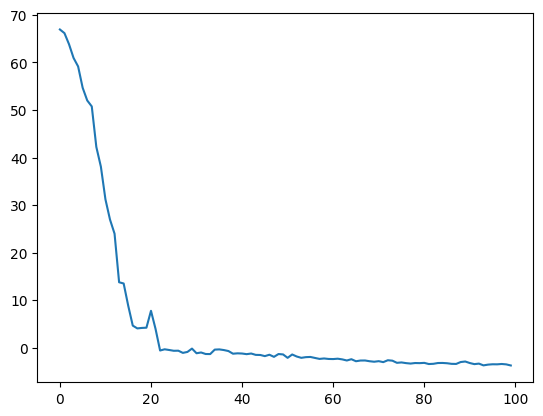

In [25]:
plot(batch_loss)